<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis_versioning_experment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This binary classification model detects malaria by classifying individual red blood cell images as infected or uninfected.
# It utilizes a dataset of 27,558 cell images from thin blood smear slides, containing both parasitized and healthy cells.
# The model leverages deep learning techniques to automate malaria detection, potentially aiding in faster and more accurate diagnosis.
### Link to the dataset: https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html
### Class - Parasitized and Uninfected

In [ ]:
!pip install -U albumentations

In [ ]:
!pip install wandb

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import random
from google.colab import files, drive
from PIL import Image
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomZoom
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yeabsiramersha58 (yeabsiramersha58-beijing-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [60]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 15,
  "BATCH_SIZE": 32,
  "DROPOUT_RATE": 0.5,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.01,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 64,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [4]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])
print(dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.CY9QW7_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [5]:
k = 0
for image, label in dataset[0]:
    with open(f'dataset/malaria_dataset_{k}.npz', mode='wb') as file:
        np.savez(file, image=image.numpy(), label=label.numpy())
    k += 1

    if k % 1000 == 0:
        print(k)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [6]:
def load_original_data():
  with wandb.init(project="Malaria-Diagnosis") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [7]:
load_original_data()

wandb: Currently logged in as: yeabsiramersha58 (yeabsiramersha58-beijing-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Adding directory to artifact (./dataset)... Done. 24.2s


In [8]:
IMG_SIZE = 224

def resize_rescale(image):
  return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0

In [9]:
def preprocess_data():
    with wandb.init(project="Malaria-Diagnosis") as run:
        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()

        print(f"Artifact downloaded to: {artifact_dir}")

        preprocessed_data = wandb.Artifact(
            name="preprocessed_dataset",
            type="preprocessed_data",
            description="A Preprocessed version of the Malaria dataset",
        )

        artifact_directory = "artifacts/new_dataset:v0/"

        dataset_x = []
        dataset_y = []

        for f in os.listdir(artifact_directory)[:1000]:
            with open(os.path.join(artifact_directory, f), 'rb') as file:
                npz_array = np.load(file, allow_pickle=True)

                x, y = npz_array['image'], npz_array['label']

                dataset_x.append(resize_rescale(x))
                dataset_y.append(y)

        with preprocessed_data.new_file("prep_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=dataset_x, dataset_y=dataset_y)

        run.log_artifact(preprocessed_data)

In [10]:
preprocess_data()

wandb: Downloading large artifact new_dataset:v0, 1419.75MB. 27558 files... 
wandb:   27558 of 27558 files downloaded.  
Done. 0:1:1.1


Artifact downloaded to: /content/artifacts/new_dataset:v0


In [66]:
def split_data():
    with wandb.init(project="Malaria-Diagnosis") as run:

        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/preprocessed_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        print(f"Artifact downloaded to: {artifact_dir}")

        train_data = wandb.Artifact(
            name="train_dataset",
            type="preprocessed_data",
            description="Training dataset",
        )
        val_data = wandb.Artifact(
            name="val_dataset",
            type="preprocessed_data",
            description="Validation dataset",
        )
        test_data = wandb.Artifact(
            name="test_dataset",
            type="preprocessed_data",
            description="Test dataset",
        )

        artifact_file = "artifacts/preprocessed_dataset:v0/prep_dataset.npz"

        with open(artifact_file, 'rb') as file:
            npz_arr = np.load(file, allow_pickle=True)
            print(npz_arr.files)

            x_data, y_data = npz_arr['dataset_x'], npz_arr['dataset_y']

        train_split = 0.8
        val_split = 0.1
        test_split = 0.1

        data_len = len(x_data)

        train_arr = [x_data[0:int(train_split * data_len)], y_data[0:int(train_split * data_len)]]
        val_arr = [x_data[int(train_split * data_len):int((train_split + val_split) * data_len)],
                   y_data[int(train_split * data_len):int((train_split + val_split) * data_len)]]
        test_arr = [x_data[int((train_split + val_split) * data_len):], y_data[int((train_split + val_split) * data_len):]]

        with train_data.new_file("train_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=train_arr[0], dataset_y=train_arr[1])

        with val_data.new_file("val_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=val_arr[0], dataset_y=val_arr[1])

        with test_data.new_file("test_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=test_arr[0], dataset_y=test_arr[1])

        run.log_artifact(train_data)
        run.log_artifact(val_data)
        run.log_artifact(test_data)

    print("Data split and logged successfully.")


In [67]:
split_data()

wandb: Downloading large artifact preprocessed_dataset:v0, 574.23MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.9


Artifact downloaded to: /content/artifacts/preprocessed_dataset:v0
['dataset_x', 'dataset_y']


Data split and logged successfully.


wandb: Downloading large artifact train_dataset:v0, 459.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.9


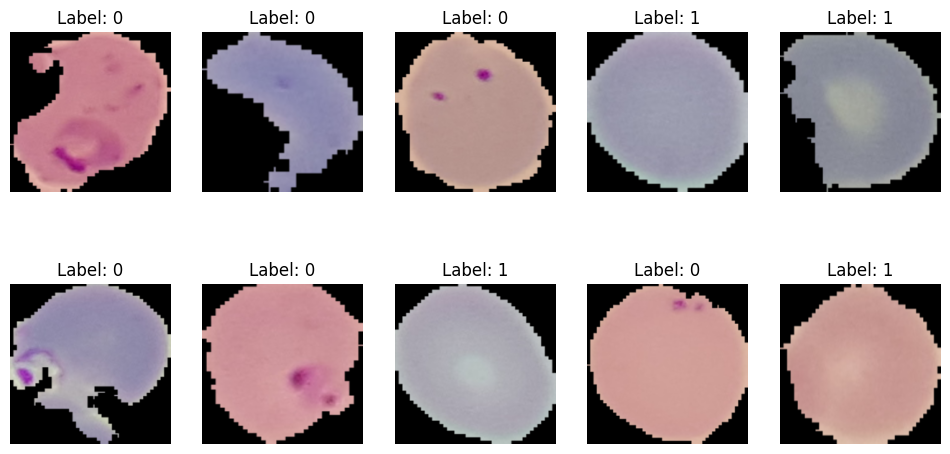

In [13]:
# Ploting images in training dataset before augmentation

run = wandb.init()
artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/train_dataset:v0', type='preprocessed_data')
artifact_dir = artifact.download()

dataset_path = f"{artifact_dir}/train_dataset.npz"
npz_arr = np.load(dataset_path, allow_pickle=True)

dataset_x, dataset_y = npz_arr['dataset_x'], npz_arr['dataset_y']

def plot_original_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i]
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

    plt.show()

plot_original_images(dataset_x, dataset_y, num_images=10)

In [68]:
IMG_SIZE = 224
augment_layers = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.ElasticTransform(p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
])

def add_noise_contrast(image):
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=image.dtype)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image

def augment(image):
    image = np.array(image * 255, dtype=np.uint8)

    augmented = augment_layers(image=image)
    image = augmented['image']

    image = image.astype(np.float32) / 255.0

    image = add_noise_contrast(image)

    return image

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [69]:
def augment_data():
    with wandb.init(project="Malaria-Diagnosis") as run:
        artifact = run.use_artifact(
            'yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/train_dataset:v0',
            type='preprocessed_data'
        )
        artifact_dir = artifact.download()
        print(f"Artifact downloaded to: {artifact_dir}")

        augmented_data = wandb.Artifact(
            name="Augmented_dataset",
            type="preprocessed_data",
            description="An Augmented version of the Malaria train dataset",
        )

        artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

        dataset_x = []
        dataset_y = []

        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)

            print(npz_array.files)
            dataset_x = npz_array['dataset_x']
            dataset_y = npz_array['dataset_y']

            augmented_images = []
            for im in dataset_x:
                augmented_images.append(augment(im))

            dataset_x = np.array(augmented_images, dtype=np.float16)

        with augmented_data.new_file("aug_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=dataset_x, dataset_y=dataset_y)

        run.log_artifact(augmented_data)
    print("Augmented data logged successfully.")

In [70]:
augment_data()

wandb: Downloading large artifact train_dataset:v0, 459.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1


Artifact downloaded to: /content/artifacts/train_dataset:v0
['dataset_x', 'dataset_y']


Augmented data logged successfully.


wandb: Downloading large artifact Augmented_dataset:v0, 229.69MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.2


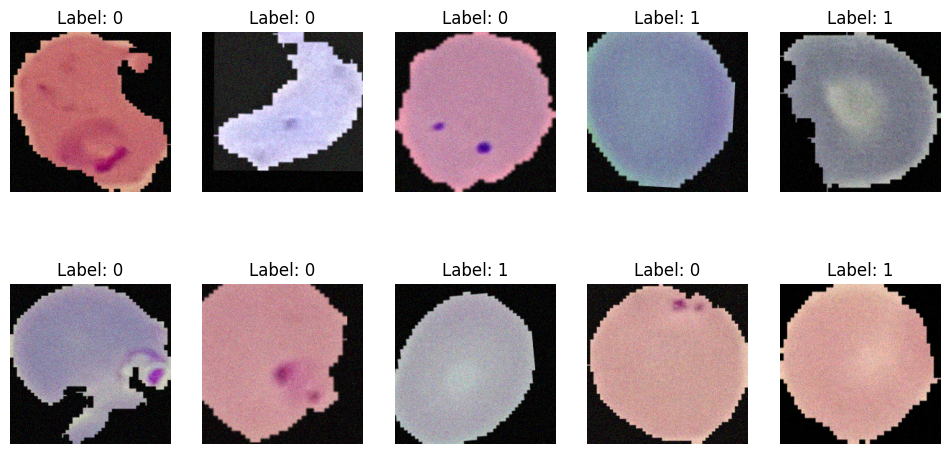

In [18]:
run = wandb.init()
artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/uncategorized/Augmented_dataset:v0', type='preprocessed_data')
artifact_dir = artifact.download()

dataset_path = f"{artifact_dir}/aug_dataset.npz"
npz_arr = np.load(dataset_path, allow_pickle=True)

dataset_x, dataset_y = npz_arr['dataset_x'], npz_arr['dataset_y']

dataset_x = dataset_x.astype(np.float32)

def plot_augmented_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i]
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

    plt.show()


# Call function to plot
plot_augmented_images(dataset_x, dataset_y, num_images=10)

In [71]:
# Define the model
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │       2,986,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,988,141 (11.40 MB)

 Trainable params: 2,987,949 (11.40 MB)

 Non-trainable params: 192 (768.00 B)

In [72]:
# Log model to wandb
def log_model():
    with wandb.init(project="Malaria-Diagnosis") as run:

        untrained_model = wandb.Artifact(
            name="Untrained_model",
            type="model",
            description="The initial version of our custom LeNet model",
            metadata={"model_name": "LeNet", "configuration": CONFIGURATION}
        )

        filename = 'lenet_model.keras'
        lenet_model.save(filename)

        untrained_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(untrained_model)

In [73]:
log_model()

In [74]:
# Having a smooth linear warmup rate at the starts improve our models stability and leads to a better outcome.
wandb.init(project="Malaria-Diagnosis")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    mode='auto',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint, WandbMetricsLogger()]

In [75]:
def train_and_log():
    with wandb.init(project="Malaria-Diagnosis") as run:
        # Load preprocessed training dataset
        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/uncategorized/Augmented_dataset:v1', type='preprocessed_data')
        artifact_dir = artifact.download()
        train_artifact_file = os.path.join(artifact_dir, "aug_dataset.npz")

        with open(train_artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)
            train_x = npz_array['dataset_x']
            train_y = npz_array['dataset_y']

        # Create training dataset
        train_d = (
            tf.data.Dataset.from_tensor_slices((train_x, train_y))
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(CONFIGURATION['BATCH_SIZE'])
            .prefetch(tf.data.AUTOTUNE)
        )

        # Load preprocessed validation dataset
        val_artifact = run.use_artifact(
            'yeabsiramersha58-beijing-institute-of-technology/uncategorized/val_dataset:v0',
            type='preprocessed_data'
        )
        val_artifact_dir = val_artifact.download()
        val_artifact_file = os.path.join(val_artifact_dir, "val_dataset.npz")

        with open(val_artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)
            val_x = npz_array['dataset_x']
            val_y = npz_array['dataset_y']

        # Create validation dataset
        val_d = (
            tf.data.Dataset.from_tensor_slices((val_x, val_y))
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(CONFIGURATION['BATCH_SIZE'])
            .prefetch(tf.data.AUTOTUNE)
        )

        # Load untrained model
        model_artifact = run.use_artifact(
            'yeabsiramersha58-beijing-institute-of-technology/uncategorized/Untrained_model:v5',
            type='model'
        )
        model_artifact_dir = model_artifact.download()
        model_file = os.path.join(model_artifact_dir, "lenet_model.keras")

        lenet_model = tf.keras.models.load_model(model_file)

        # Define metrics
        metrics = [
            TruePositives(name='tp'), FalsePositives(name='fp'),
            TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'),
            Recall(name='recall'), AUC(name='auc')
        ]

        class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
        class_weights = {i: weight for i, weight in enumerate(class_weights)}

        # Compile model
        lenet_model.compile(
            optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
            loss=BinaryCrossentropy(),
            metrics=metrics
        )

        # Ensure checkpoint directory exists
        checkpoint_dir = './checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)

        checkpoint_filepath = os.path.join(checkpoint_dir, "lenet_checkpoint.keras")

        # Train model
        lenet_model.fit(
            train_d,
            validation_data=val_d,
            epochs=CONFIGURATION["N_EPOCHS"],
            verbose=1,
            callbacks=[WandbMetricsLogger()] + callbacks
        )

        # Save trained model
        filename = 'lenet_trained.keras'
        lenet_model.save(filename)

        # Log trained model to W&B
        trained_sequential_model = wandb.Artifact(
            name="Trained_Sequential_model",
            type="model",
            description="A trained version of our model",
            metadata=CONFIGURATION,
        )

        trained_sequential_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(trained_sequential_model)

    print("Training complete and model logged successfully.")


In [76]:
train_and_log()

wandb: Downloading large artifact Augmented_dataset:v1, 229.69MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.1
wandb: Downloading large artifact val_dataset:v0, 57.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3
wandb:   1 of 1 files downloaded.  


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5031 - auc: 0.5004 - fn: 101.7600 - fp: 101.0800 - loss: 2.6778 - precision: 0.5069 - recall: 0.5127 - tn: 102.4000 - tp: 110.7600
Epoch 1: val_loss improved from inf to 2.68111, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.5033 - auc: 0.5008 - fn: 105.5385 - fp: 104.6154 - loss: 2.6802 - precision: 0.5078 - recall: 0.5130 - tn: 105.7692 - tp: 114.8462 - val_accuracy: 0.5000 - val_auc: 0.5418 - val_fn: 50.0000 - val_fp: 0.0000e+00 - val_loss: 2.6811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 50.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5774 - auc: 0.6209 - fn: 84.7600 - fp: 89.3200 - loss: 2.6120 - precision: 0.6016 - recall: 0.6026 - tn: 108.6000 - tp: 133.3200
Epoch 2: val_loss improved from 2.68111 to 2.31356, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step

epoch/accuracy,▁▁▂▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
epoch/auc,▁▁▃▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
epoch/fn,██▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
epoch/fp,██▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁
epoch/learning_rate,█████████████████▂▂▂▂▁▁▁
epoch/loss,██▇▇▅▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/precision,▁▁▂▂▃▃▅▅▅▅▆▆▇▇▇▇▇▇▇▇████
epoch/recall,▁▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
epoch/tn,▁▁▂▂▃▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇████
epoch/tp,▁▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████


Training complete and model logged successfully.


In [77]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {

    "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 2,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [64, 128, 256]
    },

    "N_DENSE_2" : {
      "values" : [64, 128, 256]
    },

    "DROPOUT_RATE":{
      "min": 0.2,
      "max": 0.3
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.01
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 0.0005,
      "max": 0.002
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: gdc1vkeb
Sweep URL: https://wandb.ai/yeabsiramersha58-beijing-institute-of-technology/uncategorized/sweeps/gdc1vkeb


In [78]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [79]:
def train():
    with wandb.init(project="Malaria-Diagnosis") as run:
        config = wandb.config
        model = model_tune(config)

        # Load preprocessed validation dataset
        val_artifact = run.use_artifact(
            'yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/val_dataset:v0',
            type='preprocessed_data'
        )
        val_artifact_dir = val_artifact.download()
        val_artifact_file = os.path.join(val_artifact_dir, "val_dataset.npz")

        with open(val_artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)
            val_x = npz_array['dataset_x']
            val_y = npz_array['dataset_y']

        val_d = (
            tf.data.Dataset.from_tensor_slices((val_x, val_y))
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(CONFIGURATION['BATCH_SIZE'])
            .prefetch(tf.data.AUTOTUNE)
        )

        model.compile(
              optimizer= Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_d, epochs=5, callbacks=[WandbMetricsLogger()] + callbacks )


count = 5
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: a7huajs5 with config:
wandb: 	DROPOUT_RATE: 0.23834363353848517
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0019012612807337507
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 256
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.0048531748761240865


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
wandb: Downloading large artifact val_dataset:v0, 57.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.4812 - loss: 2.2147 - learning_rate: 0.0019
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.6850 - loss: 2.2720 - learning_rate: 0.0019
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.7262 - loss: 2.4409 - learning_rate: 0.0019
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7132 - loss: 2.6971 - learning_rate: 0.0019
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.6986 - loss: 2.7517 - learning_rate: 0.0019


epoch/accuracy,▁▁▅▅██▇▇▇▇
epoch/epoch,▁▁▃▃▅▅▆▆██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▂▂▄▄▇▇██
epoch/accuracy,0.71
epoch/epoch,4
epoch/learning_rate,0.0019
epoch/loss,2.76722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mpboej94 with config:
wandb: 	DROPOUT_RATE: 0.20557097817756964
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0006200120703989317
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.007575501929586208


wandb: Downloading large artifact val_dataset:v0, 57.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5778 - loss: 3.7487 - learning_rate: 6.2001e-04
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.8638 - loss: 3.4028 - learning_rate: 6.2001e-04
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8489 - loss: 3.4045 - learning_rate: 6.2001e-04
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9385 - loss: 3.3594 - learning_rate: 6.2001e-04
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8740 - loss: 3.3956 - learning_rate: 6.2001e-04


epoch/accuracy,▁▁▆▆▇▇██▇▇
epoch/epoch,▁▁▃▃▅▅▆▆██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▂▂▁▁▁▁▂▂
epoch/accuracy,0.87
epoch/epoch,4
epoch/learning_rate,0.00062
epoch/loss,3.40214


wandb: Agent Starting Run: rv1qqeg9 with config:
wandb: 	DROPOUT_RATE: 0.2730371082974509
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0012209208602839631
wandb: 	N_DENSE_1: 256
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.0069586294983678765


wandb: Downloading large artifact val_dataset:v0, 57.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.6206 - loss: 5.7048 - learning_rate: 0.0012
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.7707 - loss: 6.0449 - learning_rate: 0.0012
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.8151 - loss: 6.3504 - learning_rate: 0.0012
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.8382 - loss: 6.5347 - learning_rate: 0.0012
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.8185 - loss: 6.4186 - learning_rate: 0.0012


epoch/accuracy,▁▁▅▅▆▆████
epoch/epoch,▁▁▃▃▅▅▆▆██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▅▅▇▇██▇▇
epoch/accuracy,0.83
epoch/epoch,4
epoch/learning_rate,0.00122
epoch/loss,6.39991


wandb: Agent Starting Run: w673deea with config:
wandb: 	DROPOUT_RATE: 0.2707925282310172
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0018238687949385937
wandb: 	N_DENSE_1: 256
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.006567809064556389


wandb: Downloading large artifact val_dataset:v0, 57.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 0.5738 - loss: 5.5956 - learning_rate: 0.0018
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.8058 - loss: 6.5965 - learning_rate: 0.0018
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.8115 - loss: 7.6171 - learning_rate: 0.0018
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.8617 - loss: 8.1252 - learning_rate: 0.0018
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.9048 - loss: 8.2032 - learning_rate: 0.0018


epoch/accuracy,▁▁▅▅▆▆▇▇██
epoch/epoch,▁▁▃▃▅▅▆▆██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▄▄▇▇████
epoch/accuracy,0.9
epoch/epoch,4
epoch/learning_rate,0.00182
epoch/loss,8.20951


wandb: Agent Starting Run: 7p8hnpzh with config:
wandb: 	DROPOUT_RATE: 0.27030321179593764
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.00132897867549032
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 2
wandb: 	REGULARIZATION_RATE: 0.0036290287597065263


wandb: Downloading large artifact val_dataset:v0, 57.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5680 - loss: 1.5860 - learning_rate: 0.0013
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.7780 - loss: 1.3372 - learning_rate: 0.0013
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.7342 - loss: 1.4818 - learning_rate: 0.0013
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.8066 - loss: 1.5390 - learning_rate: 0.0013
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.8723 - loss: 1.4860 - learning_rate: 0.0013


epoch/accuracy,▁▁▅▅▅▅▆▆██
epoch/epoch,▁▁▃▃▅▅▆▆██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▁▁▅▅██▆▆
epoch/accuracy,0.85
epoch/epoch,4
epoch/learning_rate,0.00133
epoch/loss,1.51428
